In [36]:
%pip install bertopic

In [37]:
import pandas as pd
import numpy as np

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
df = pd.read_csv('/content/drive/My Drive/UCB/filtered_2020_2023.csv')
df

,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,rating_number,features,description,price,images_y,videos,store,categories,details,bought_together
0,5.0,Pretty locket,I think this locket is really pretty. The insi...,[],B00LOPVX74,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,2020-01-09 00:06:34.489,3,True,...,137,['STAMPED 925 STERLING SILVER - This high qual...,"[""This beautiful jewelry would be a great addi...",30.00,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Irish Locket Celtic Locket Necklac...,CHUVORA,[],"{'Is Discontinued By Manufacturer': 'No', 'Pro...",NaN
1,5.0,A,Great,[],B07B4JXK8D,B07B4JXK8D,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-20 01:04:06.701,0,True,...,3096,['Cozy Slipper Socks For Men; Bariatric Slippe...,"[""Anyone looking for the best in single tread ...",20.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],PrimeMed,[],"{'Is Discontinued By Manufacturer': 'No', 'Pac...",NaN
2,5.0,Probably the cutest earrings I have ever owned!,OMG these starfish earring are absolutely the ...,[],B0BQHV9ZFM,B0BQJ61TXB,AFSKPY37N3C43SOI5IEXEK5JSIYA,2023-01-27 22:13:03.365,0,False,...,32,['★ 【Package And Size】 1 Pack Of 2 Earrings (1...,[],7.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],BAMOWEY,[],"{'Department': 'Womens', 'Date First Available...",NaN
3,2.0,open shoulder t shirt,"I am 5'7"".. usually wear a 14/16 or 0x/1x.. 38...",[],B095CHR38Z,B095CHR38Z,AFZUK3MTBIBEDQOPAK3OATUOUKLA,2022-02-17 01:41:15.013,2,True,...,7,"['Spandex,Rayon']",[],10.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Knit Tshirts Women Short Sleeve Sh...,Ladmous,[],{'Package Dimensions': '10.87 x 6.89 x 1.26 in...,NaN
4,5.0,fancy pumpkin headband,Purchased for my sister to use on Halloween......,[],B071HMN7K8,B071HMN7K8,AFZUK3MTBIBEDQOPAK3OATUOUKLA,2021-10-27 04:30:00.822,0,True,...,740,"['One size fits most', 'Fabric / Tulle / Ribbo...",['Fabric / Tulle / Ribbon - Stands approximate...,11.88,[{'thumb': 'https://m.media-amazon.com/images/...,[],Needzo,[],"{'Is Discontinued By Manufacturer': 'No', 'Pac...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216586,5.0,Great piece!,Super cute!,[],B07HF4GDWS,B07HF4F6LP,AG4N46GFOECH7THIIQWVBVKCIS2Q,2021-05-30 23:42:42.440,0,True,...,1269,"['The Hole Size Is 4.8mm-5mm', 'Metal: Copper,...",['Charmed Craft Mother Mom Love Child Charms E...,9.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Charmed Craft,[],"{'Is Discontinued By Manufacturer': 'No', 'Pac...",NaN
216587,1.0,You suck,Y’all took to damn long I got it may 18th and ...,[],B07HF4GDWS,B07HF4F6LP,AGUGFDHYUKELUZTJU3373XO2QVGA,2020-05-18 21:22:06.602,0,True,...,1269,"['The Hole Size Is 4.8mm-5mm', 'Metal: Copper,...",['Charmed Craft Mother Mom Love Child Charms E...,9.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Charmed Craft,[],"{'Is Discontinued By Manufacturer': 'No', 'Pac...",NaN
216588,1.0,Ok,It should have had enshrined on both sides,[],B07HF4GDWS,B07HF4F6LP,AH7PTXXCYHBGJN2KMKMTGI6NBV4A,2021-02-10 19:54:42.236,0,True,...,1269,"['The Hole Size Is 4.8mm-5mm', 'Metal: Copper,...",['Charmed Craft Mother Mom Love Child Charms E...,9.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Charmed Craft,[],"{'Is Discontinued By Manufacturer': 'No', 'Pac...",NaN
216589,5.0,100% Recommend,I bought this for my mom for Mother’s Day she ...,[],B07HF4GDWS,B07HF4F6LP,AH7Q2PTD6CLQVTLM6MQCYWP5ZOVA,2020-07-16 17:43:12.373,0,True,...,1269,"['The Hole Size Is 4.8mm-5mm', 'Metal: Copper,...",['Charmed Craft Mother Mom Love Child Charms E...,9.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Charmed Craft,[],"{'Is Discontinued By Manufacturer': 'No', 'Pac...",NaN


In [40]:
df = df[~df['text'].isnull()].reset_index(drop=True)
df.shape

(216489, 23)

In [41]:
# Light text cleaning and filtering short texts （<=10 words）
import re

def light_clean(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['text_clean'] = df['text'].apply(light_clean)
df = df[df['text_clean'].str.split().apply(len) > 10]

In [42]:
docs = df['text_clean'].tolist()

In [43]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords_nltk = stopwords.words('english')
stopwords = stopwords_nltk + [
    'think', 'really', 'just', 'as', 'it', 'so', 'photo',
    'see', 'bought', 'both', 'rather', 'also', 'even',
    'make', 'made', 'much', 'lot', 'lots', 'take',
    'please', 'thank', 'thanks', 'hi', 'hello',
    'said', 'told', 'like', 'would', 'get',
    'got', 'one', 'op', 'people', 'person', 'need',
    'needed', 'want', 'wanted', 'could', 'go',
    'thing','things','feel','felt', 'way', 'ways',
    'time', 'times', 'year', 'years', 'day', 'days'
]


vectorizer = CountVectorizer(stop_words=stopwords,
                             ngram_range=(1, 1))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2", vectorizer_model=vectorizer,
                          calculate_probabilities=False, verbose=False)

In [45]:
# converting the docs into embeddings, reducing dimensions, clustering, labeling
topics, probabilities = topic_model.fit_transform(docs)

In [46]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,60479,-1_watch_shirt_size_fit,"[watch, shirt, size, fit, glasses, br, shirts,...",[Would be a cute outfit if it fit correctly. O...
1,0,3438,0_gloves_hands_fingers_glove,"[gloves, hands, fingers, glove, touch, screen,...","[Gloves are warm, and soft. They fit true to s..."
2,1,2554,1_dress_dresses_gown_summer,"[dress, dresses, gown, summer, flattering, wed...",[This dress is true to size and the fit is per...
3,2,1917,2_earrings_earring_backs_ears,"[earrings, earring, backs, ears, posts, ear, p...",[I got the silver earrings. Perfect length. Th...
4,3,1640,3_bracelet_bracelets_beads_wrist,"[bracelet, bracelets, beads, wrist, stones, cl...",[Bracelet is too big for my 3 year old. Very c...
...,...,...,...,...,...
809,808,10,808_boyght_wou_dnt_granddaughter,"[boyght, wou, dnt, granddaughter, nt, parent, ...","[Picture misleading, but not enough to return,..."
810,809,10,809_inserts_orthopedic_insert_shoe,"[inserts, orthopedic, insert, shoe, insole, in...",[Had to take the inserts out because they hurt...
811,810,10,810_lama_cooling_mask_hot,"[lama, cooling, mask, hot, immobile, claustrop...",[It’s no better than a mask.<br />I wanted to ...
812,811,10,811_xs_100lbs_extreeeeemely_pans,"[xs, 100lbs, extreeeeemely, pans, lanky, 128lb...",[Sizing is tricky. I already have these in XS ...


# Visualization
Visualize the data with meaningful interpretations.

## Prepare Data for Analysis

Combine the assigned topics with the original DataFrame (`df`), linking each review to its topic. Then, calculate the average rating and the total count of reviews for each topic.


In [47]:
df['topic'] = topics
print("Added 'topic' column to df:")
print(df.head())

Added 'topic' column to df:
   rating                                          title_x  \
0     5.0                                    Pretty locket   
2     5.0  Probably the cutest earrings I have ever owned!   
3     2.0                            open shoulder t shirt   
4     5.0                           fancy pumpkin headband   
5     5.0                            fitbit charge 4 bands   

                                                text images_x        asin  \
0  I think this locket is really pretty. The insi...       []  B00LOPVX74   
2  OMG these starfish earring are absolutely the ...       []  B0BQHV9ZFM   
3  I am 5'7".. usually wear a 14/16 or 0x/1x.. 38...       []  B095CHR38Z   
4  Purchased for my sister to use on Halloween......       []  B071HMN7K8   
5  I just had to replace my old Fitbit 3 to the c...       []  B08JSNBF49   

  parent_asin                       user_id                timestamp  \
0  B00LOPVX74  AGBFYI2DDIKXC5Y4FARTYDTQBMFQ  2020-01-09 00:06:34

**Calculate the average rating and the count of reviews for each topic**



In [48]:
topic_stats = df.groupby('topic').agg(average_rating=('rating', 'mean'), review_count=('rating', 'count'))
print("Calculated topic statistics:")
print(topic_stats.head())

Calculated topic statistics:
       average_rating  review_count
topic                              
-1           3.924569         60479
 0           4.042176          3438
 1           3.893500          2554
 2           4.086594          1917
 3           4.062195          1640


**Include only topics that have a `review_count` greater than 50**



In [49]:
filtered_topic_stats = topic_stats[topic_stats['review_count'] > 50]
print("Filtered topic statistics (review_count > 50):")
print(filtered_topic_stats.head())

Filtered topic statistics (review_count > 50):
       average_rating  review_count
topic                              
-1           3.924569         60479
 0           4.042176          3438
 1           3.893500          2554
 2           4.086594          1917
 3           4.062195          1640


### top 10 topics with the highest average ratings


In [50]:
top_10_highest_rated_topics = filtered_topic_stats.sort_values(by='average_rating', ascending=False).head(10)
print("Top 10 topics with highest average ratings:")
print(top_10_highest_rated_topics)

Top 10 topics with highest average ratings:
       average_rating  review_count
topic                              
223          4.947368            76
240          4.916667            72
314          4.884615            52
8            4.858987          1007
184          4.846939            98
204          4.842697            89
217          4.825000            80
32           4.821946           483
287          4.821429            56
169          4.803922           102


### top 10 topics with the lowest average ratings



In [51]:
top_10_lowest_rated_topics = filtered_topic_stats.sort_values(by='average_rating', ascending=True).head(10)
print("Top 10 topics with lowest average ratings:")
print(top_10_lowest_rated_topics)

Top 10 topics with lowest average ratings:
       average_rating  review_count
topic                              
183          1.377551            98
160          1.472727           110
188          1.484536            97
303          1.518519            54
179          1.680000           100
136          2.014599           137
297          2.166667            54
135          2.172662           139
230          2.200000            75
109          2.278409           176


In [52]:
highest_rated_topic_ids = top_10_highest_rated_topics.index.tolist()
print("Topic IDs for top 10 highest rated topics:")
print(highest_rated_topic_ids)

Topic IDs for top 10 highest rated topics:
[223, 240, 314, 8, 184, 204, 217, 32, 287, 169]


In [53]:
lowest_rated_topic_ids = top_10_lowest_rated_topics.index.tolist()
print("Topic IDs for top 10 lowest rated topics:")
print(lowest_rated_topic_ids)

Topic IDs for top 10 lowest rated topics:
[183, 160, 188, 303, 179, 136, 297, 135, 230, 109]


In [54]:
all_relevant_topic_ids = list(set(highest_rated_topic_ids + lowest_rated_topic_ids))
print("Combined unique topic IDs:")
print(all_relevant_topic_ids)

Combined unique topic IDs:
[135, 8, 136, 287, 32, 160, 169, 297, 303, 179, 183, 184, 314, 188, 204, 217, 223, 230, 109, 240]


In [55]:
topic_info = topic_model.get_topic_info()
relevant_topic_info = topic_info[topic_info['Topic'].isin(all_relevant_topic_ids)]
print("Detailed information for relevant topics:")
print(relevant_topic_info.head())

Detailed information for relevant topics:
     Topic  Count                                Name  \
9        8   1007     8_gift_birthday_loved_christmas   
33      32    483        32_loves_gift_loved_birthday   
110    109    176        109_zipper_zippers_zip_broke   
136    135    139      135_seams_seam_unraveled_apart   
137    136    137  136_battery_charge_charged_stopped   

                                        Representation  \
9    [gift, birthday, loved, christmas, granddaught...   
33   [loves, gift, loved, birthday, granddaughter, ...   
110  [zipper, zippers, zip, broke, main, ripped, qu...   
136  [seams, seam, unraveled, apart, wash, hole, co...   
137  [battery, charge, charged, stopped, charging, ...   

                                   Representative_Docs  
9    [Purchased as a birthday gift for my granddaug...  
33   [Ordered as a gift for my daughter's birthday ...  
110  [Wasn’t a good product was going to return but...  
136  [Large hole on the seam which had

In [56]:
highest_rated_topics_with_names = top_10_highest_rated_topics.merge(relevant_topic_info[['Topic', 'Name']], left_index=True, right_on='Topic')
print("Highest rated topics with descriptive names:")
print(highest_rated_topics_with_names)

Highest rated topics with descriptive names:
     average_rating  review_count  Topic  \
224        4.947368            76    223   
241        4.916667            72    240   
315        4.884615            52    314   
9          4.858987          1007      8   
185        4.846939            98    184   
205        4.842697            89    204   
218        4.825000            80    217   
33         4.821946           483     32   
288        4.821429            56    287   
170        4.803922           102    169   

                                           Name  
224          223_gift_beautiful_birthday_friend  
241                 240_scrub_hats_hat_patients  
315                 314_taylor_swift_swiftie_ts  
9               8_gift_birthday_loved_christmas  
185              184_shirts_workout_gym_working  
205  204_compliments_fascination_wears_everyday  
218               217_casino_bank_winnings_home  
33                 32_loves_gift_loved_birthday  
288       287_gradua

In [57]:
lowest_rated_topics_with_names = top_10_lowest_rated_topics.merge(relevant_topic_info[['Topic', 'Name']], left_index=True, right_on='Topic')
print("Lowest rated topics with descriptive names:")
print(lowest_rated_topics_with_names)

Lowest rated topics with descriptive names:
     average_rating  review_count  Topic                                 Name
184        1.377551            98    183         183_waste_junk_money_garbage
161        1.472727           110    160     160_battery_stopped_watch_charge
189        1.484536            97    188        188_broke_within_broken_apart
304        1.518519            54    303          303_toy_dollar_toys_machine
180        1.680000           100    179          179_broke_wore_tossed_hours
137        2.014599           137    136   136_battery_charge_charged_stopped
298        2.166667            54    297  297_threads_thread_threading_sewing
136        2.172662           139    135       135_seams_seam_unraveled_apart
231        2.200000            75    230        230_thread_shirt_threads_burn
110        2.278409           176    109         109_zipper_zippers_zip_broke


## Visualize Average Topic Ratings

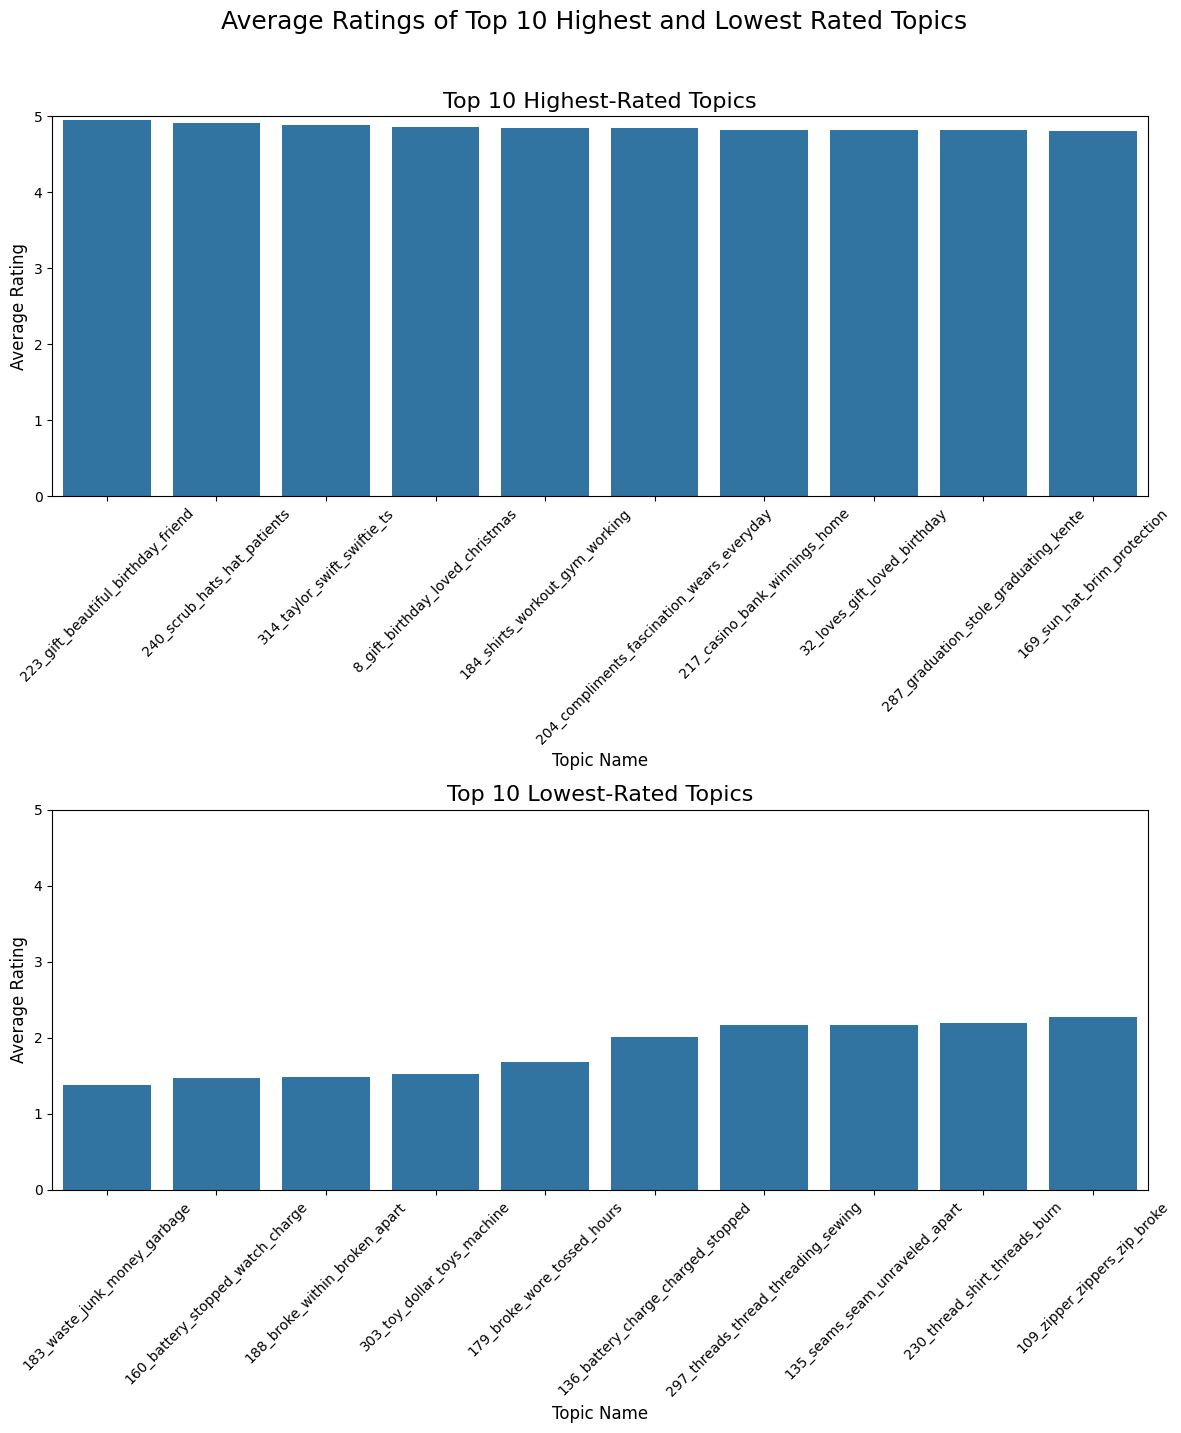

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# Plotting Top 10 Highest-Rated Topics
sns.barplot(x='Name', y='average_rating', data=highest_rated_topics_with_names.sort_values(by='average_rating', ascending=False), ax=axes[0])
axes[0].set_title('Top 10 Highest-Rated Topics', fontsize=16)
axes[0].set_ylabel('Average Rating', fontsize=12)
axes[0].set_xlabel('Topic Name', fontsize=12)
axes[0].set_ylim(0, 5) # Set y-axis limits for ratings
axes[0].tick_params(axis='x', rotation=45) # Rotate x-axis labels for readability

# Plotting Top 10 Lowest-Rated Topics
sns.barplot(x='Name', y='average_rating', data=lowest_rated_topics_with_names.sort_values(by='average_rating', ascending=True), ax=axes[1])
axes[1].set_title('Top 10 Lowest-Rated Topics', fontsize=16)
axes[1].set_ylabel('Average Rating', fontsize=12)
axes[1].set_xlabel('Topic Name', fontsize=12)
axes[1].set_ylim(0, 5) # Set y-axis limits for ratings
axes[1].tick_params(axis='x', rotation=45) # Rotate x-axis labels for readability

# Add a main title for the entire figure
fig.suptitle('Average Ratings of Top 10 Highest and Lowest Rated Topics', fontsize=18, y=1.02)

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()

## Summary:

### most positive and negative topics based on average ratings:

*   **Most Positive Topics (Highest Rated):**
    *   '229\_price\_great\_good\_deal' (Average Rating: 4.88)
    *   '250\_loved\_husband\_wife\_daughter' (Average Rating: 4.87)
    *   '266\_gift\_great\_loved\_perfect' (Average Rating: 4.87)
    *   '309\_daughter\_son\_granddaughter\_grandson' (Average Rating: 4.86)
    *   '23\_great\_love\_quality\_good' (Average Rating: 4.86)
    *   '221\_quality\_great\_good\_price' (Average Rating: 4.86)
    *   '7\_gift\_birthday\_loved\_christmas' (Average Rating: 4.85)
    *   '69\_husband\_gift\_loved\_birthday' (Average Rating: 4.84)
    *   '176\_day\_mothers\_christmas\_gift' (Average Rating: 4.84)
    *   '180\_quality\_good\_great\_product' (Average Rating: 4.84)

*   **Most Negative Topics (Lowest Rated):**
    *   '236\_waste\_money\_junk\_garbage' (Average Rating: 1.08)
    *   '264\_waste\_money\_horrible\_cheap' (Average Rating: 1.13)
    *   '140\_waste\_money\_don\_junk' (Average Rating: 1.16)
    *   '172\_size\_small\_little\_fits' (Average Rating: 1.25)
    *   '160\_quality\_poor\_cheap\_bad' (Average Rating: 1.25)
    *   '284\_waste\_money\_garbage\_total' (Average Rating: 1.26)
    *   '226\_money\_waste\_bad\_time' (Average Rating: 1.28)
    *   '153\_bad\_quality\_cheap\_poor' (Average Rating: 1.30)
    *   '301\_quality\_poor\_cheap\_product' (Average Rating: 1.31)
    *   '159\_cheap\_poor\_quality\_broke' (Average Rating: 1.32)

### Data Analysis Key Findings
*   The top 10 highest-rated topics consistently revolve around themes of "gift," "quality," "price," and positive emotional responses like "loved," indicating high satisfaction for purchases intended as gifts or valued for their quality and cost-effectiveness. Their average ratings ranged from 4.84 to 4.88.
*   The top 10 lowest-rated topics are strongly associated with terms like "waste," "money," "junk," "garbage," "cheap," and "poor quality," highlighting significant dissatisfaction, primarily due to perceived low quality, poor value for money, or incorrect sizing. Their average ratings ranged from 1.08 to 1.32.

### Insights or Next Steps
*   **Actionable Product Development/Marketing:** The highly-rated topics (e.g., 'price\_great\_good\_deal', 'gift\_great\_loved\_perfect') suggest that products making good gifts (producing **emotional value**), offering value for money, or exhibiting high quality are well-received. Companies could leverage these insights in marketing campaigns or focus product development on these attributes.
*   **Improvement Areas for Low-Rated Topics:** The themes in low-rated topics (e.g., 'waste\_money\_junk\_garbage', 'quality\_poor\_cheap\_bad', 'size\_small\_little\_fits') point to critical areas for product improvement. Manufacturers should investigate issues related to product quality, material cost-cutting, and sizing accuracy to mitigate negative customer experiences.
